In [1]:
from heeps.pupil import create_stop, dodecagon, hexagon
from heeps.config import read_config, update_config
from heeps.util.img_processing import resize_img
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

In [2]:
diam_ext_M1 = 37.812                # average M1 diam (from ravc_optim.ipynb)
diam_int_M1 = 10.196
ls_misalign_x = 0#.01
ls_misalign_y = 0#.01

# load useful config params
conf = read_config(npupil=1023,     # high res
                   misalign_x=ls_misalign_x, misalign_y=ls_misalign_y,
                   )
npupil = conf['npupil']
pupil_img_size = conf['pupil_img_size']
diam_nominal = conf['diam_nominal']
diam_ext_AG = conf['diam_ext']      # all-glass
diam_int_AG = conf['diam_int']
ravc_r_opt = conf['ravc_r']         # cf. ravc optimisation
ravc_t_opt = conf['ravc_t']
seg_width = conf['seg_width']
npupil_L = update_config(**dict(read_config(), band='L'))['npupil']
npupil_N = update_config(**dict(read_config(), band='N2'))['npupil']
print('npupil=%s, npupil_L=%s, npupil_N=%s'%(npupil, npupil_L, npupil_N))

npupil=1023, npupil_L=285, npupil_N=119


# 0/ ELT pupil

### 2025-Q1

 - spi_width = 202 mm
 - AP_width = 386 mm (M1 crane) 
 - Spiders enveloppe: 308mm and 475mm resp.

**Changes in dRspi (FDR -> 2025-Q1)**
 To simplify we consider a delta thickness = 100mm between real widths and the enveloppes.
 Since the oversize margins are computed based on the enveloppes, most dRspi values have been incremented by 0.26% (= 100 / 38542 ) between FDR and 2025-Q1

**Symmetric LS stops**  
Some stops (all LMS) needs to have a 6-fold symmetry: all spider widths should be the same. This is done using the parameter `force_sym`, in which case the spider oversizing is computed relative to the `max(spi_width, AP_width)`

**APP-IMG stop**
The APP-IMG stop given in this notebook is symmetric and not exact. For the correct mask, see the fits file.

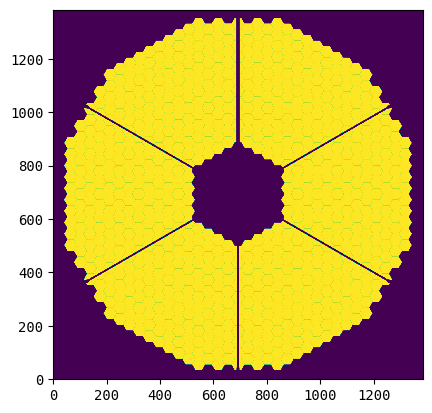

In [3]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
fname = 'ELT_fullM1_feb2025.fits'
if os.path.isfile(fname):
    mask_M1_2025 = fits.getdata(fname)
else:
    mask_M1_2025 = resize_img(fits.getdata('eso/ELT_binary_fullM1_feb2025_10k.fits'), 1385)
    #mask_M1_2025 = resize_img(fits.getdata('eso/ELT_fullM1_feb2025.fits'), npupil)
    fits.writeto(fname, mask_M1_2025, overwrite=False)

plt.imshow(mask_M1_2025, origin='lower');
plt.show()

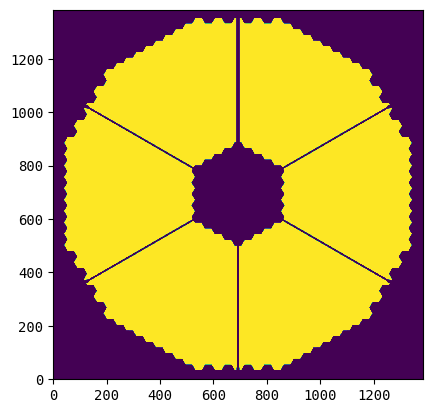

In [4]:
fname = 'ELT_fullM1_feb2025_noseg.fits'
if os.path.isfile(fname):
    mask_M1_2025_no_seg = fits.getdata(fname)
else:
    mask_M1_2025_no_seg = resize_img(fits.getdata('eso/ELT_binary_fullM1_feb2025_nosegment_10k.fits'), 1385)
    #mask_M1_2025 = resize_img(fits.getdata('eso/ELT_fullM1_feb2025.fits'), npupil)
    fits.writeto(fname, mask_M1_2025_no_seg, overwrite=False)

plt.imshow(mask_M1_2025_no_seg, origin='lower');
plt.show()

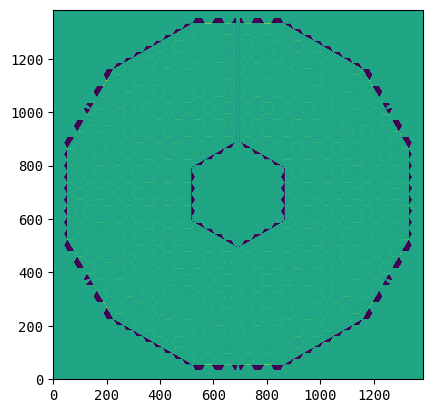

In [ ]:
conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['add_seg'] = False
conf['npupil'] = 1385
conf['spi_angles'] = [0,60,120,180,240,300]  # regular spider angles in deg
conf['spi_width'] = 0.202                    # regular spider width in m
conf['AP_angles'] = [180]                    # Asymetric Pupil spider angles in deg
conf['AP_width'] = 0.386                     # AP spider width in m (AP_width > spi_width)
  
conf['seg_width'] = 1.417   

# Check pupil generation
pupil_check = create_stop(dRext=0,
                   dRint=0,
                   dRspi=0,
                   circ_ext=False,
                   circ_int=False,
                   **conf)
plt.figure()
plt.imshow(pupil_check - mask_M1_2025)
plt.show()

# os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
# fits.writeto('ELT_toto_noseg_gox.fits', toto, overwrite=True)

### Nov 2024: New spider shadow (5x31cm + 1x54cm)
Check allglass vs fullM1

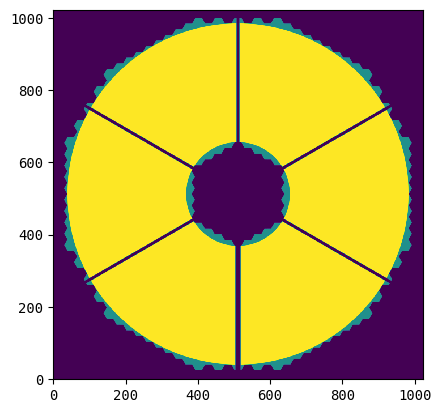

In [5]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))

# try:
#     mask_AG = fits.getdata('mask_AG_nov2024_%s.fits'%npupil)
# except FileNotFoundError:
#     mask_AG = resize_img(fits.getdata('eso/mask_allglass.fits')
#                        * fits.getdata('eso/SpiderShadow_nov2024.fits'), npupil)
#     fits.writeto('mask_AG_nov2024_%s.fits'%npupil, mask_AG)
# try:
#     mask_M1 = fits.getdata('eso/mask_M1_nov2024_%s.fits'%npupil)
#     #mask_M1 = fits.getdata('/Users/cdelacroix/Desktop/data_1_pup_conv.fits')
# except FileNotFoundError:
#     mask_M1 = resize_img(fits.getdata('eso/mask_fullM1.fits')
#                        * fits.getdata('eso/SpiderShadow_nov2024.fits'), npupil)
#     fits.writeto('eso/mask_M1_nov2024_%s.fits'%npupil, mask_M1)
mask_AG = resize_img(fits.getdata('eso/mask_allglass.fits'), npupil)
mask_M1 = resize_img(fits.getdata('eso/mask_fullM1.fits'), npupil)
mask_spi = resize_img(fits.getdata('eso/SpiderShadow_nov2024.fits'), npupil)

M1_allglass = np.float32(mask_M1 * mask_spi * (1 + mask_AG)/2)
fits.writeto('mask_M1_allglass_nov2024_%s.fits'%npupil, M1_allglass, overwrite=True)
plt.imshow(M1_allglass, origin='lower');
plt.show()

mask_M1 = mask_M1 * mask_spi

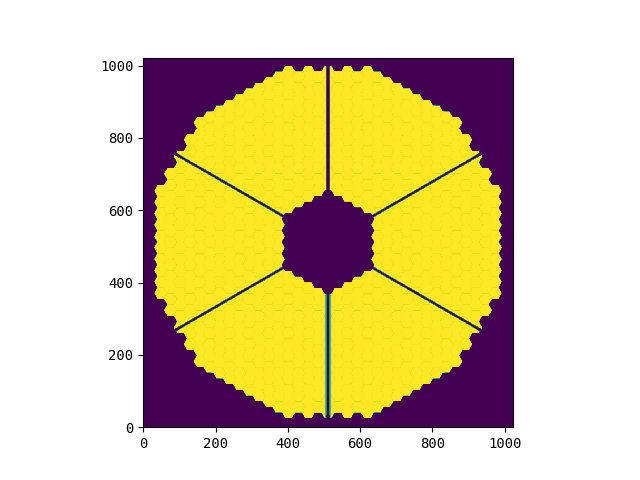

In [16]:
%matplotlib widget
mask_M1_2024 = resize_img(fits.getdata('ELT_fullM1_nov2024.fits'), npupil)
plt.figure()
plt.imshow(mask_M1_2024 + mask_M1_2025)
plt.show()

diam_dodecagon = 36.8765
diam_hexagon = 10.0529


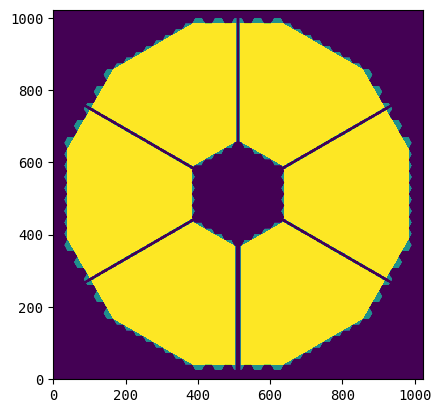

In [68]:
# a bit of geometry to find the dodecagon and hexagon edges ...
alpha = np.arcsin(seg_width/diam_ext_AG)
beta = np.pi/6 - np.arcsin(seg_width*np.sin(np.pi/6)/diam_int_AG)
diam_dodecagon = np.cos(alpha)*diam_ext_AG
diam_hexagon = np.cos(beta)*diam_int_AG
print('diam_dodecagon = %s\ndiam_hexagon = %s'%(np.round(diam_dodecagon, 4), 
    np.round(diam_hexagon, 4)))
r_ext = diam_dodecagon/pupil_img_size
r_int = diam_hexagon/pupil_img_size
M1_dodhex = np.float32(mask_M1 * mask_spi * (2 - dodecagon(r_ext, npupil) - hexagon(r_int, npupil))/2)
# fits.writeto('eso/mask_M1_dodhex_nov2024_%s.fits'%npupil, M1_dodhex, overwrite=True)
plt.imshow(M1_dodhex, origin='lower');
plt.show()

# 1/ L band 

In [16]:
mask_M1 = mask_M1_2025_no_seg

conf['npupil'] = 1385 # npupil_L
mask_L = resize_img(mask_M1, conf['npupil'])

sym_stop = False # all L-band stops do not need to be symmetric
ow = False

### 1.0/ L-band IMG (SPM-LM)


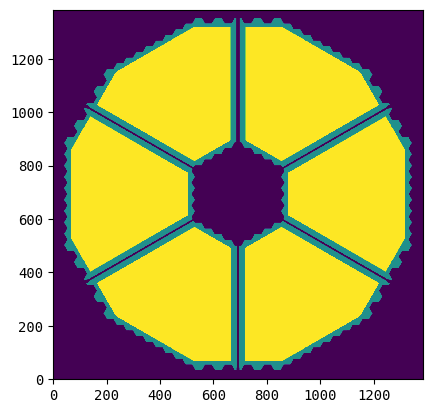

In [17]:
# stop_params = (0.0209, 0.0209, 0.0291)    # FDR value
stop_params = (0.0209, 0.0209, 0.0317)      # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                   # SPM-LM does not need to be symmetric
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1],
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
try:
    fits.writeto('ls/ls_SPM_LM_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
        (conf['npupil'], *stop_params), mask, overwrite=ow)
except:
    print('[Error] failed to save file')
plt.imshow(mask_L * (1 + mask)/2, origin='lower');
plt.show()

mask_IMG_LM = mask * 1 #(1 + mask)/2

### 1.1/ L-band RAVC (RLS-LM)
#### Calculate RAVC parameters (wrt all-glass diameters)

In [18]:
# all-glass parameters
r_obstr_AG = diam_int_AG/diam_ext_AG
ravc_t_AG = 1 - (r_obstr_AG**2 + r_obstr_AG*np.sqrt(r_obstr_AG**2 + 8))/4
ravc_r_AG = r_obstr_AG/np.sqrt(1 - ravc_t_AG)
diam_ravc_AG = ravc_r_AG*diam_ext_AG
print('diam_ravc_AG = %s (t=%s, r=%s)'%(np.round(diam_ravc_AG, 4),
    np.round(ravc_t_AG, 2), np.round(ravc_r_AG, 2)))
# full-M1 parameters
r_obstr_M1 = diam_int_M1/diam_ext_M1
ravc_t_M1 = 1 - (r_obstr_M1**2 + r_obstr_M1*np.sqrt(r_obstr_M1**2 + 8))/4
ravc_r_M1 = r_obstr_M1/np.sqrt(1 - ravc_t_M1) * (diam_ext_M1/diam_ext_AG)
diam_ravc_M1 = ravc_r_M1*diam_ext_AG
print('diam_ravc_M1 = %s (t=%s, r=%s)'%(np.round(diam_ravc_M1, 4),
    np.round(ravc_t_M1, 2), np.round(ravc_r_M1, 2)))
# optimal parameters (cf. ravc optimisation)
diam_ravc_opt = ravc_r_opt*diam_ext_AG
print('diam_ravc_opt = %s (t=%s, r=%s)'%(np.round(diam_ravc_opt, 4), 
    np.round(ravc_t_opt, 3), np.round(ravc_r_opt, 3)))

diam_ravc_AG = 22.9287 (t=0.76, r=0.62)
diam_ravc_M1 = 22.2647 (t=0.79, r=0.6)
diam_ravc_opt = 19.1537 (t=0.791, r=0.519)


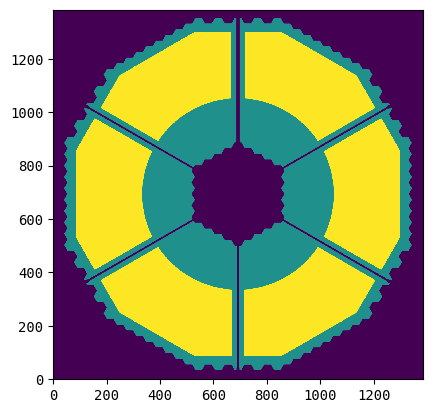

In [19]:
# stop_params = (0.0477, 0.04, 0.0249)        # FDR values
stop_params = (0.0477, 0.04, 0.0275)          # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_ravc_opt
conf['force_sym'] = sym_stop                   # RLS-LM does not need to be symmetric
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1],
                   dRspi=stop_params[2],
                   circ_ext=False, 
                   circ_int=True, **conf)
try:
    fits.writeto('ls/ls_RLS_LM_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
        (conf['npupil'], *stop_params), mask, overwrite=ow)
except:
    pass
plt.imshow(mask_L * (1 + mask)/2 , origin='lower');
plt.show()

### 1.2/ L-band CVC (CLS-LM)

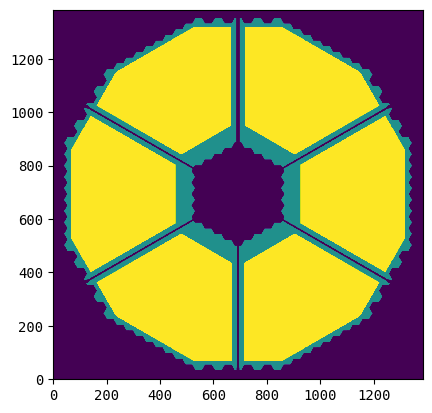

In [20]:
stop_params = (0.0209, 0.09, 0.0245)    # FDR
stop_params = (0.0209, 0.09, 0.0271)    # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                # CLS-LM does not need to be symmetric
mask = create_stop(dRext=stop_params[0], 
                   dRint=stop_params[1], 
                   dRspi=stop_params[2],
                   circ_ext=False, 
                   circ_int=False,**conf)
try:
    fits.writeto('ls/ls_CLS_LM_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
        (conf['npupil'], *stop_params), mask, overwrite=ow)
except:
    print('[Error] failed to save file')
plt.imshow(mask_L * (1 + mask)/2, origin='lower');
mask_CVC_LM = mask * 1
plt.show()

### 1.3/ L-band CLC (ULS-LM)

ls_dRext=0.1095, ls_dRint=0.0491, ls_dRspi=0.0343


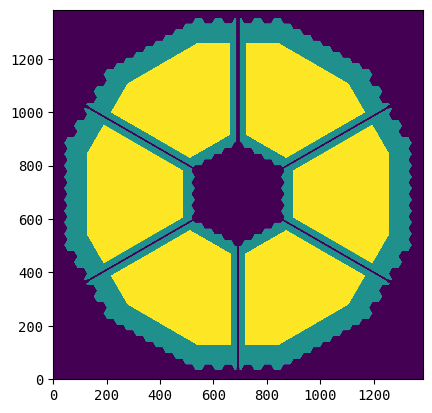

In [55]:
# values from Muskan wrt diam_nominal
ls_dRext = np.round(diam_ext_AG/diam_nominal - 0.848, 4)
ls_dRint = np.round(0.34 - diam_int_AG/diam_nominal, 4)
# ls_dRspi = 0.0317                 # FDR
ls_dRspi = 0.0343                   # 2025-Q1
print('ls_dRext=%s, ls_dRint=%s, ls_dRspi=%s'%(ls_dRext, ls_dRint, ls_dRspi))
stop_params = (ls_dRext, ls_dRint, ls_dRspi) # = (0.1095, 0.0491, 0.0343) 2025-Q1
conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop            # ULS-LM should be symmetric
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1], 
                   dRspi=stop_params[2],
                   circ_ext=False, circ_int=False, **conf)
# fits.writeto('ls/ls_ULS_LM_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
#     (npupil_L, *stop_params), mask, overwrite=True)
plt.figure()
plt.imshow(mask_L * (1 + mask)/2, origin='lower')
plt.show()

### 1.4/ L-band APP-IMG (APP-LM)
Correct APP-IMG mask is under fits file format.

Version made here is symmetric and only an approximation

[Warning] Forcing spiders to have all the same sizes.


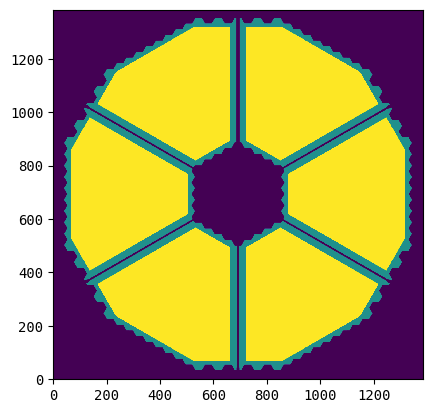

In [56]:
# stop_params = (0.0209, 0.0209, 0.0291)  # FDR value 
stop_params = (0.0209, 0.0209, 0.0331)  # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = True            # APP is made here symmetric 

mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1], 
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
# fits.writeto('ls/ls_APP-IMG_L_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
#     (npupil_L, *stop_params), mask, overwrite=True)
plt.imshow(mask_L * (1 + mask)/2, origin='lower');
plt.show()

# 2/ N2 band

In [21]:
mask_M1 = mask_M1_2025_no_seg

conf['npupil'] = 1385 #npupil_N
mask_N = resize_img(mask_M1, conf['npupil'])

sym_stop = False # all N-band stops do not need to be symmetric
ow=False

### 2.0/ N2-band IMG (SPM-N)

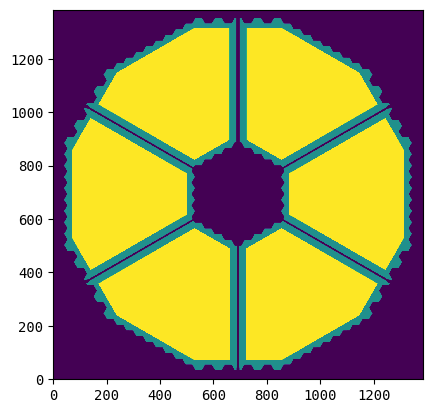

In [22]:
# stop_params = (0.0268, 0.0268, 0.0357)      # FDR dimensions
stop_params = (0.0268, 0.0268, 0.0383)      # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                   # SPM-N does not need to be symmetric
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1],
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
try:
    fits.writeto('ls/ls_SPM_N_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
        (conf['npupil'], *stop_params), mask, overwrite=ow)
except:
    print('[Error] failed to save file')
plt.imshow(mask_N * (1 + mask)/2, origin='lower');
plt.show()

mask_IMG_N = mask * 1 #(1 + mask)/2

### 2.1/ N2-band CVC (CLS-N)

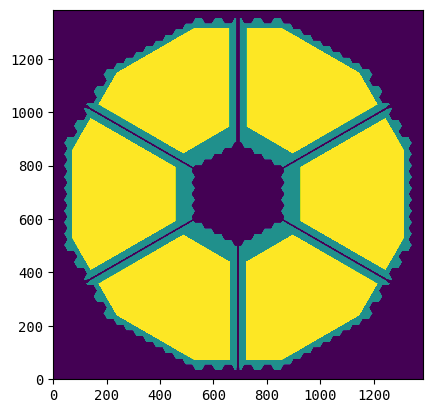

In [23]:
# stop_params = (0.0268, 0.09, 0.0357)    # FDR 
stop_params = (0.0268, 0.09, 0.0383)    # 2025-Q1 

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                  
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1], 
                   dRspi=stop_params[2], 
                   circ_ext=False,
                   circ_int=False, **conf)
try:
    fits.writeto('ls/ls_CLS_N_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
        (conf['npupil'], *stop_params), mask, overwrite=ow)
except:
    print('[Error] failed to save file')
plt.imshow(mask_N * (1 + mask)/2, origin='lower');
plt.show()

### 2.2/ N2-band CLC (ULS-N)

ls_dRext=0.1045, ls_dRint=0.0511, ls_dRspi=0.0409


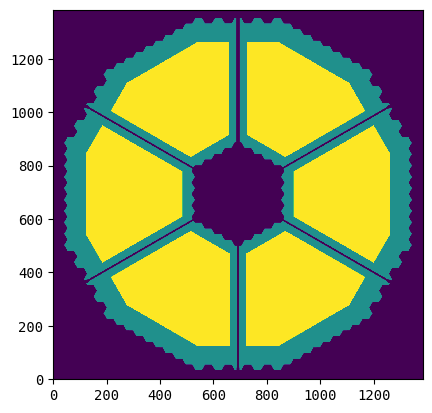

In [60]:
# values from Muskan wrt diam_nominal
ls_dRext = np.round(diam_ext_AG/diam_nominal - 0.853, 4)
ls_dRint = np.round(0.342 - diam_int_AG/diam_nominal, 4)
# ls_dRspi = 0.0383           # FDR
ls_dRspi = 0.0409             # 2025-Q1

print('ls_dRext=%s, ls_dRint=%s, ls_dRspi=%s'%(ls_dRext, ls_dRint, ls_dRspi))
stop_params = (ls_dRext, ls_dRint, ls_dRspi)   # = 0.1045, 0.0511, 0.0409 -- 2025-Q1
conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                   
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1], 
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
# fits.writeto('ls/ls_ULS_N_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
#     (npupil_N, *stop_params), mask, overwrite=True)
plt.imshow(mask_N * (1 + mask)/2, origin='lower');
plt.show()

# 3/ LMS

In [61]:
%matplotlib inline 

mask_M1 = mask_M1_2025_no_seg

conf['npupil'] = 1385 # npupil_L
mask_L = resize_img(mask_M1, conf['npupil'])

sym_stop = True # all LMS stops should be symmetric (6-fold spider symmetry)

### 3.0/ Normal LMS (SPM-LMS)

[Warning] Forcing spiders to have all the same sizes.


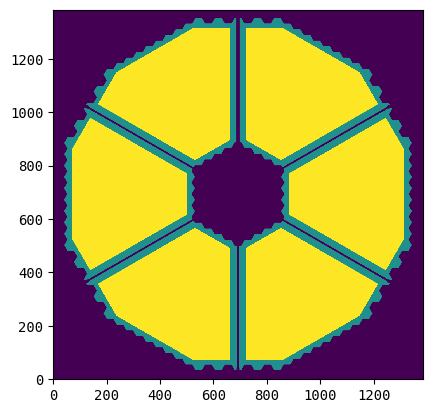

In [62]:
stop_params = (0.0241, 0.0241, 0.0334)      # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                   
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1],
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
# fits.writeto('ls/ls_SPM_LMS_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
#     (npupil_L, *stop_params), mask, overwrite=True)
plt.figure()
plt.imshow(mask_L * (1 + mask)/2, origin='lower')
plt.show()

### 3.1/ RAVC LMS (RLS-LMS)

[Warning] Forcing spiders to have all the same sizes.


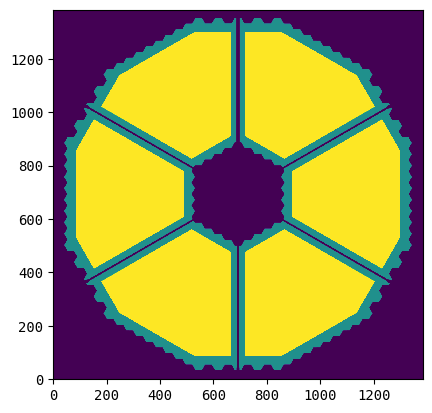

In [63]:
stop_params = (0.0468, 0.0400, 0.0306)      # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                   
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1],
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
# fits.writeto('ls/ls_RLS_LMS_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
#     (npupil_L, *stop_params), mask, overwrite=True)
plt.figure()
plt.imshow(mask_L * (1 + mask)/2, origin='lower')
plt.show()

### 3.2/ CVC LMS (CLS-LMS)

[Warning] Forcing spiders to have all the same sizes.


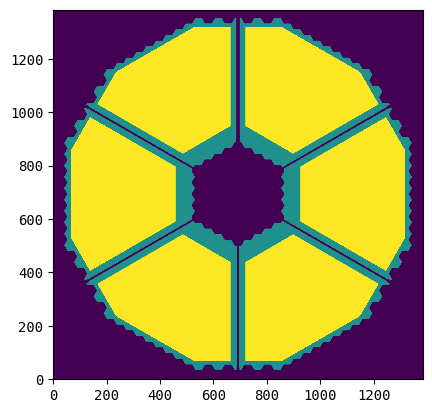

In [64]:
stop_params = (0.0218, 0.0900, 0.0314)      # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                   
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1],
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
# fits.writeto('ls/ls_CLS_LMS_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
#     (npupil_L, *stop_params), mask, overwrite=True)
plt.figure()
plt.imshow(mask_L * (1 + mask)/2, origin='lower')
plt.show()

### 3.3/ CLC LMS (ULS-LMS)

[Warning] Forcing spiders to have all the same sizes.


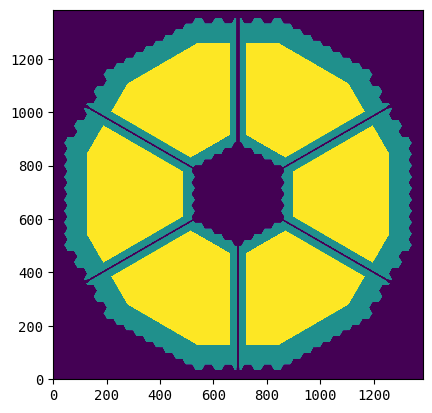

In [65]:
stop_params = (0.1095, 0.0491, 0.0343)      # 2025-Q1

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                   
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1],
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
# fits.writeto('ls/ls_ULS_LMS_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
#     (npupil_L, *stop_params), mask, overwrite=True)
plt.figure()
plt.imshow(mask_L * (1 + mask)/2, origin='lower')
plt.show()

### 3.4/ APP-LMS

[Warning] Forcing spiders to have all the same sizes.


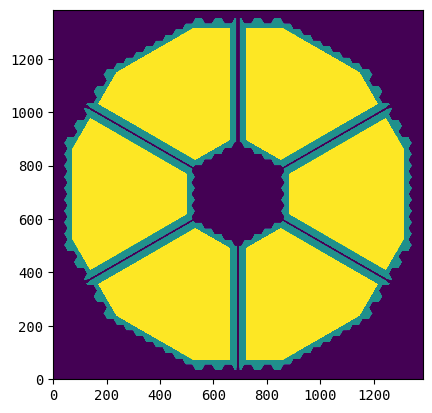

In [66]:
stop_params = (0.0241, 0.0241, 0.0308)      # FDR dimensions
stop_params = (0.0241, 0.0241, 0.0348)      # FDR dimensions

conf['diam_ext'] = diam_ext_AG
conf['diam_int'] = diam_int_AG
conf['force_sym'] = sym_stop                   
mask = create_stop(dRext=stop_params[0],
                   dRint=stop_params[1], 
                   dRspi=stop_params[2],
                   circ_ext=False,
                   circ_int=False, **conf)
# fits.writeto('ls/ls_APP-LMS_L_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
#     (npupil_L, *stop_params), mask, overwrite=True)
plt.figure()
plt.imshow(mask_L * (1 + mask)/2, origin='lower');
plt.show()